## In this file, we show a simple example on how to use deep convolutional neural network to classify raw EEG signals.

### Step 1: Load EEG signals. 

> We load the EEG Motor Movement/Imagery Dataset (https://physionet.org/content/eegmmidb/1.0.0/)

> We will only load parts of the "task 3" data for simplicity  (open and close both fists or both feet)

> We use sliding window methods to augument the data 

This tutorial uses the MNE open-source Python package for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, NIRS, and more.

In [30]:
# !pip install mne

In [31]:
# Essential libraries used for loading the dataset
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
import numpy as np

In [32]:
#Get epochs with sliding window 
def getEpochs(subjects, runs, event_id):
    # set your path to save the dataset
    dataset_path = './EEGBCI_dataset'
    tmin, tmax = -1., 4. 
    subject_row = []

    for subject in subjects:
        raw_fnames = eegbci.load_data(subject, runs, dataset_path)
        #concatenate multiply runs into one instance
        subject_row.append(concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]))
    raw = concatenate_raws([row for row in subject_row])

    eegbci.standardize(raw)
    # set channel names standard_1005
    montage = make_standard_montage('standard_1005') # Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
    raw.set_montage(montage)

    #Strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    #Apply band-pass filter 
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')  # band pass filter 
    
    #Get events from raw signal 
    events, _ = events_from_annotations(raw, event_id=event_id)

    #Choose only EEG signals 
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

    #Get epochs from raw data  
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

    epochs_data = epochs.get_data()
    labels = epochs.events[:, -1] - 1
        
    return epochs_data, labels

In [33]:
%%capture
#Load task 3 data 
#The data will automatically start download if you don't have it in the path you set 
# Note: It might take a while to download the data
#Choose subjects id from 1 to 20 
subjects = [i for i in range(1, 21)]

#Choose all task 3 runs 
task3_runs = [5, 9, 13]

#Set task event id
task3_event_id = dict(T1=1, T2=2) #T1 open fists, T2 open feet

#Get all task3 epoch data and its corresponding labels 
task3_epochs_data, task3_labels = getEpochs(subjects, task3_runs, task3_event_id)

In [34]:
#Take a look at the data and label size
# We have 888 samples, each sample can be viewed as a 2D matrix where the height 64 represents EEG data channels, 
# the width 801 represents there are 801 time steps in one event. 
print(task3_epochs_data.shape)
print(task3_labels.shape)

(888, 64, 801)
(888,)


In [35]:
# Reshape the data to the format (NHWC), where N is the number of samples (instances), 
# H is the height (in this case 64 for the 64 EEG electrodes),
# W is the width (in this case the number of time steps in one event),
# C is the number of channels (in this case 1).
# Reshape the data to (888, 64, 801, 1) and scale the data by 10000
X = task3_epochs_data.reshape(task3_epochs_data.shape[0], 64, 801, 1).astype(np.float32) * 10000
y = task3_labels

print(X.shape)  # Expected output: (888, 64, 801, 1)
print(y.shape)  # Expected output: (888,)

(888, 64, 801, 1)
(888,)


### Step 2: Create a Deep convolutional neural network specially designed for EEG data classification

In [37]:
#Check GPU availablity
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [38]:
# tools for plotting graphs
from matplotlib import pyplot as plt

In [39]:
#Control GPU memory growth
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True # Allow memory allocation to grow beyond the initial default size
session = InteractiveSession(config=config)

c:\Users\vangelis\miniconda3\envs\ml\Lib\site-packages\tensorflow\python\client\session.py:1770: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [40]:
#Keras models
import tensorflow.keras as keras 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D, Cropping2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Reshape
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

In [41]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')  # Set the data format to channels_last

# Build the model
def EEG_ConvNet(nb_classes, Chans=64, Samples=160, dropoutRate=0.5):
    # Start the model
    input_main = Input((Chans, Samples, 1)) # Input layer
    block1 = Conv2D(30, (1, 8),   # Convolution along time with filters of size [1 x 8]
                    input_shape=(Chans, Samples, 1),
                    kernel_constraint=max_norm(2., axis=(0, 1, 2)))(input_main)
    block1 = Conv2D(30, (Chans, 1), use_bias=False,  # Convolution across channels with filters of size [#channels x 1]
                    kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
    block1 = BatchNormalization(axis=-1, epsilon=1e-05, momentum=0.1)(block1)  # Update BatchNormalization axis to -1
    block1 = Activation('elu')(block1)
    block1 = MaxPooling2D(pool_size=(1, 8), strides=(1, 3))(block1)
    block1 = Activation('elu')(block1)
    block1 = Dropout(dropoutRate)(block1)
    
    block2 = Conv2D(50, (1, 3),   # Convolution along time with filters of size [1 x 3]
                    kernel_constraint=max_norm(2., axis=(0, 1, 2)))(block1)
    block2 = BatchNormalization(axis=-1, epsilon=1e-05, momentum=0.1)(block2)  # Update BatchNormalization axis to -1
    block2 = Activation('elu')(block2)
    block2 = MaxPooling2D(pool_size=(1, 4), strides=(1, 2))(block2)
    block2 = Dropout(dropoutRate)(block2)
    
    flatten = Flatten()(block2)
    dense = Dense(nb_classes, kernel_constraint=max_norm(0.5))(flatten)
    softmax = Activation('softmax')(dense)
    
    return Model(inputs=input_main, outputs=softmax)

number_classes = 2
model = EEG_ConvNet(nb_classes=2, Chans=64, Samples=801)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 801, 1)]      0         
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 794, 30)       270       
                                                                 
 conv2d_7 (Conv2D)           (None, 1, 794, 30)        57600     
                                                                 
 batch_normalization_4 (Bat  (None, 1, 794, 30)        120       
 chNormalization)                                                
                                                                 
 activation_8 (Activation)   (None, 1, 794, 30)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 1, 263, 30)        0         
 g2D)                                                      

### Step 3: Train the EEG_ConvNet model with the EEG data we have loaded

In [42]:
def train(X_train, Y_train, X_val, Y_val, model, batch_size = 128, epochs = 100, filename = 'results'):
    opt = keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filename+"Rand42.h5", save_best_only=True, monitor="val_loss"
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
        ),
    ]
    
    
    fittedModel = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, verbose = 2, validation_data=(X_val, Y_val), 
                       callbacks = callbacks)
    return fittedModel
    

In [43]:
#Function for plotting the training accuracy and training loss
def training_plots(fittedModel, epochs):
    loss = fittedModel.history['loss']
    val_loss = fittedModel.history['val_loss']
    
    acc = fittedModel.history['accuracy']
    val_acc = fittedModel.history['val_accuracy']
    
    plt.rcParams["figure.figsize"] = (20,10)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    
    num_epochs = range(epochs)
    ax1.plot(num_epochs, loss, 'r', label='Training loss')
    ax1.plot(num_epochs, val_loss, 'b', label='Validation loss')
    ax1.set_title('Training and validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('loss')
    ax1.legend()
    
    ax2.plot(num_epochs, acc, 'r', label='Training acc')
    ax2.plot(num_epochs, val_acc, 'b', label='Validation acc')
    ax2.set_title('Training and validation acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('acc')
    ax2.legend()
    
    plt.show()

In [44]:
from sklearn.model_selection import train_test_split

# Reshape the data to NHWC format and split into train, validation, and test sets
chans = 64
samples = 801

# Split 1: split the original dataset into training and test parts (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split 2: Further split the training part from split 1 into a training and a validation set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)


In [45]:
print(f'X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}, X_val.shape = {X_val.shape}')

X_train.shape = (568, 64, 801, 1), X_test.shape = (178, 64, 801, 1), X_val.shape = (142, 64, 801, 1)


In [46]:
#Create a EEG_ConvNet model and train it
n_epochs = 100 # For how many epochs to train
fittedmodel = train(X_train, Y_train, X_val, Y_val, model, epochs = n_epochs, filename = 'EEG_ConvNettask3')

Epoch 1/100
5/5 - 5s - loss: 1.1272 - accuracy: 0.5035 - val_loss: 0.7079 - val_accuracy: 0.4930 - lr: 5.0000e-04 - 5s/epoch - 1s/step
Epoch 2/100


c:\Users\vangelis\miniconda3\envs\ml\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 - 4s - loss: 0.8766 - accuracy: 0.5176 - val_loss: 0.7017 - val_accuracy: 0.5282 - lr: 5.0000e-04 - 4s/epoch - 777ms/step
Epoch 3/100
5/5 - 4s - loss: 0.8540 - accuracy: 0.5000 - val_loss: 0.7348 - val_accuracy: 0.5141 - lr: 5.0000e-04 - 4s/epoch - 783ms/step
Epoch 4/100
5/5 - 4s - loss: 0.7747 - accuracy: 0.5651 - val_loss: 0.6969 - val_accuracy: 0.5070 - lr: 5.0000e-04 - 4s/epoch - 786ms/step
Epoch 5/100
5/5 - 4s - loss: 0.7647 - accuracy: 0.5211 - val_loss: 0.6891 - val_accuracy: 0.5423 - lr: 5.0000e-04 - 4s/epoch - 794ms/step
Epoch 6/100
5/5 - 4s - loss: 0.7486 - accuracy: 0.5687 - val_loss: 0.6884 - val_accuracy: 0.5563 - lr: 5.0000e-04 - 4s/epoch - 777ms/step
Epoch 7/100
5/5 - 4s - loss: 0.7571 - accuracy: 0.5299 - val_loss: 0.7056 - val_accuracy: 0.5423 - lr: 5.0000e-04 - 4s/epoch - 810ms/step
Epoch 8/100
5/5 - 4s - loss: 0.7098 - accuracy: 0.5739 - val_loss: 0.6864 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 4s/epoch - 790ms/step
Epoch 9/100
5/5 - 4s - loss: 0.6872 - accuracy

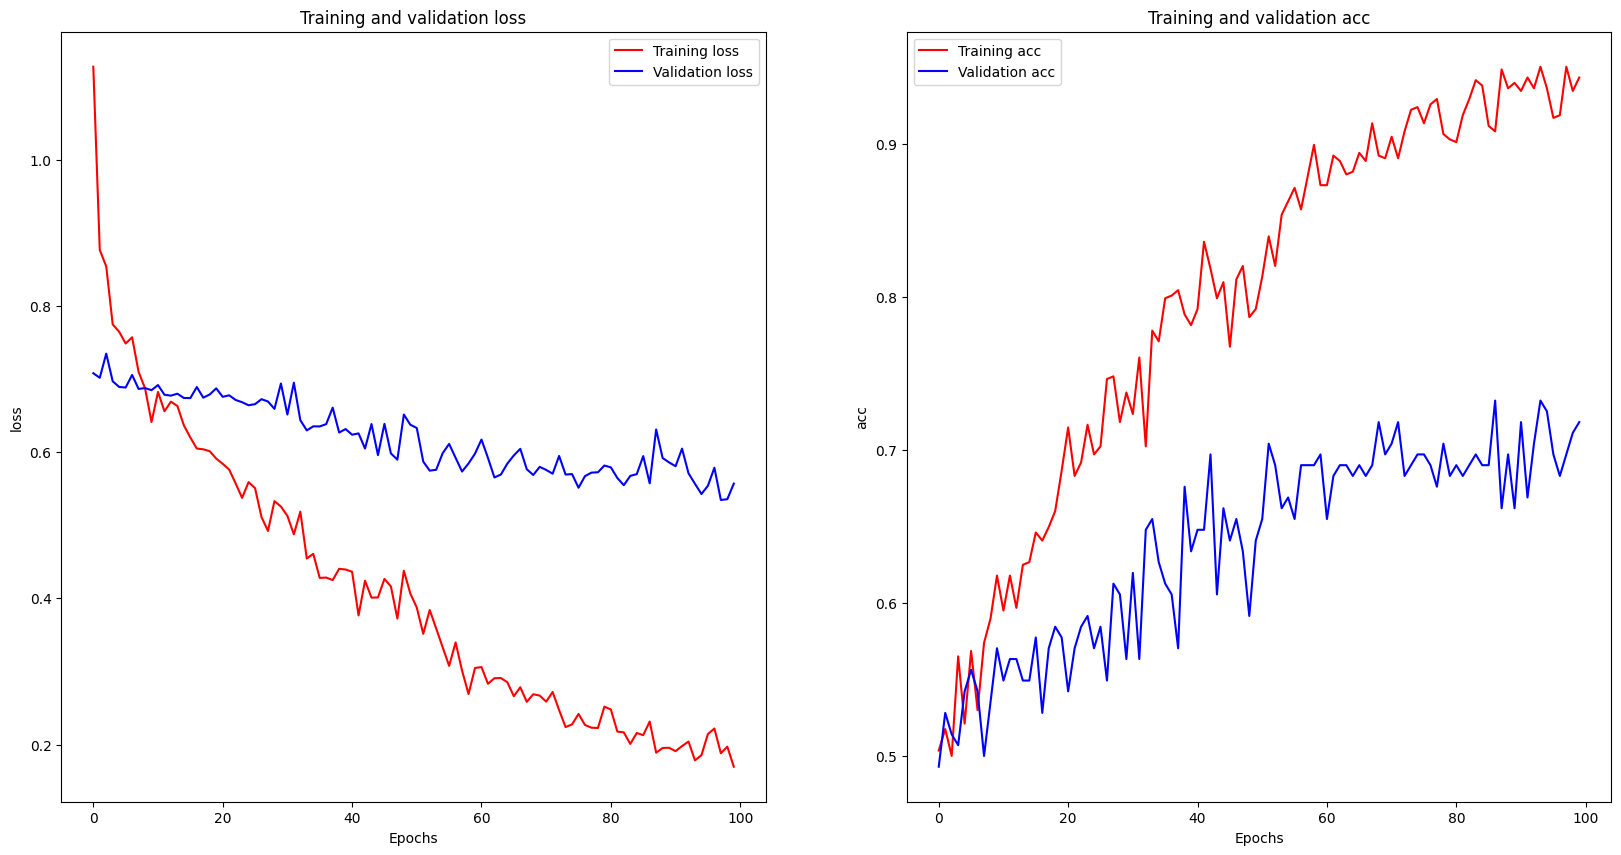

In [47]:
#Plot training loss and accuracy 
training_plots(fittedmodel, epochs = n_epochs)

### Step 4: Evaluate the model on the test set 

In [48]:
from sklearn.metrics import confusion_matrix

In [49]:
def test(model, X_test, Y_test, filename):
    model.load_weights(filename+'Rand42.h5')
    probs = model.predict(X_test)
    preds = probs.argmax(axis = 1)  
    acc = np.mean(preds == Y_test)
    
    return acc, preds

In [50]:
accuracy, predictions = test(model, X_test, Y_test, 'EEG_ConvNettask3')

6/6 [==============================] - 0s 49ms/step


In [51]:
print('Classification accuracy on test set is: {0:.3f}'.format(accuracy))

Classification accuracy on test set is: 0.775


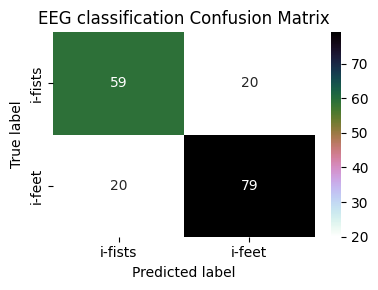

In [52]:
import pandas as pd
import seaborn as sns

labels = ['i-fists', 'i-feet']
cm = confusion_matrix(Y_test, predictions)

cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)
plt.rcParams["figure.figsize"] = (4,3)
fig = plt.figure()
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
plt.title('EEG classification Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()